# Оптимизация маркетинговых стратегий для увеличения выручки интернет-магазина через анализ A/B-теста

**Описание проекта**

***Контекст***

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты. 

**Описание данных**

***Данные для первой части***
- Файл /datasets/hypothesis.csv. Скачать датасет
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

***Данные для второй части***

Файл /datasets/orders.csv. Скачать датасет
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv. Скачать датасет
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

Основные этапы проекта:

**Шаг 1: Предобработка данных**
Сначала я загрузила данные о гипотезах, заказах и посетителях. После осмотра, я удостоверилась, что данные качественные: пропусков нет, дубликаты отсутствуют. Даты были представлены в формате object, что потребовало их преобразования в datetime для удобства анализа.

**Шаг 2: Приоритизация гипотез**
Я применила фреймворки ICE и RICE для приоритизации гипотез и обнаружила, что приоритеты меняются в зависимости от учета охвата изменений (параметр Reach). Это позволило мне определить, какие изменения окажут наибольшее влияние на пользователей.

**Шаг 3: Анализ A/B-теста**
Я построила графики кумулятивной выручки, среднего чека, и относительного изменения среднего чека и количества заказов между группами. Это дало мне возможность наблюдать за динамикой теста и выявить аномальные значения.

**Шаг 4: Статистический анализ**
Я проверила статистическую значимость различий в среднем количестве заказов и среднем чеке между группами. Использовала критерий Манна-Уитни, чтобы определить наличие значимых различий между группами A и B как по "сырым", так и по "очищенным" данным.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

**Обзор и предобработка данных**

In [2]:
# Загрузка данных из файлов
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [3]:
# Настройка отображения, чтобы названия гипотез выводились целиком
pd.set_option('display.max_colwidth', None)

# Показать первые пять строк датафрейма hypothesis
hypothesis.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


In [4]:
# Вывести информацию о DataFrame hypothesis, включая количество непустых значений и типы данных
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [5]:
# Показать первые пять строк датафрейма orders
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [6]:
# Получить информацию о датафрейме orders, включая типы данных и количество непустых значений
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [7]:
# Показать первые пять строк датафрейма visitors
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [8]:
# Получить информацию о датафрейме visitors, включая типы данных и количество непустых значений
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [9]:
# Проверить наличие дубликатов в датафрейме hypothesis и посчитать их количество
duplicates_hypothesis = hypothesis.duplicated().sum()
print(f'Количество дубликатов в hypothesis: {duplicates_hypothesis}')

# Проверить наличие дубликатов в датафрейме orders и посчитать их количество
duplicates_orders = orders.duplicated().sum()
print(f'Количество дубликатов в orders: {duplicates_orders}')

# Проверить наличие дубликатов в датафрейме visitors и посчитать их количество
duplicates_visitors = visitors.duplicated().sum()
print(f'Количество дубликатов в visitors: {duplicates_visitors}')

Количество дубликатов в hypothesis: 0
Количество дубликатов в orders: 0
Количество дубликатов в visitors: 0


Я провела первоначальный анализ предоставленных нам таблиц. В ходе осмотра данных было выявлено, что они не содержат пропусков, что является хорошим показателем их качества. Однако были обнаружены некоторые моменты, требующие внимания: в частности, столбцы, предназначенные для хранения дат, были обнаружены в формате `object`, что не является оптимальным выбором для дальнейшей работы с этими данными. Такой тип данных может усложнить выполнение операций, связанных с датами и временем, и потребует их преобразования в более подходящий формат, например, `datetime64[ns]`, для упрощения анализа и обработки.

In [10]:
# Получаем уникальные значения в колонке 'group' из датафрейма orders
unique_groups_orders = orders['group'].unique()
# Выводим на экран уникальные группы, найденные в датафрейме orders
print(f'Уникальные группы в orders: {unique_groups_orders}')

# Получаем уникальные значения в колонке 'group' из датафрейма visitors
unique_groups_visitors = visitors['group'].unique()
# Выводим на экран уникальные группы, найденные в датафрейме visitors
print(f'Уникальные группы в visitors: {unique_groups_visitors}')

Уникальные группы в orders: ['B' 'A']
Уникальные группы в visitors: ['A' 'B']


In [11]:
# Находим минимальную дату в колонке 'date' датафрейма orders, что соответствует дате начала теста
test_start_date = orders['date'].min()
# Находим максимальную дату в колонке 'date' датафрейма orders, что соответствует дате окончания теста
test_end_date = orders['date'].max()

# Выводим дату начала теста
print(f'Дата начала теста: {test_start_date}')
# Выводим дату окончания теста
print(f'Дата окончания теста: {test_end_date}')

Дата начала теста: 2019-08-01
Дата окончания теста: 2019-08-31


In [12]:
# Проверяем уникальность пользователей в группах
unique_groups_per_user = orders.groupby('visitorId')['group'].nunique()
users_in_both_groups = unique_groups_per_user[unique_groups_per_user > 1].count()

print(f'Количество пользователей, попадающих в обе группы: {users_in_both_groups}')

Количество пользователей, попадающих в обе группы: 58


- Уникальность групп: В обоих датафреймах orders и visitors идентифицированы уникальные группы 'A' и 'B', что указывает на наличие двух различных групп для тестирования. Это стандартная практика для A/B тестирования, где одна группа обычно является контрольной, а другая — экспериментальной.

- Период тестирования: Тестирование проводилось в течение месяца, с 1 по 31 августа 2019 года. Этот временной промежуток позволяет собрать достаточно данных для анализа результатов теста.

- Проблема с пересечением групп: Было выявлено, что некоторые пользователи попадают в обе тестовые группы, что является серьёзной проблемой для A/B тестирования. Такое пересечение может исказить результаты теста, так как одни и те же пользователи подвергаются воздействию обоих условий теста, что может привести к невозможности чётко определить, какое воздействие привело к изменениям в поведении или результатах.

**Часть 1. Приоритизация гипотез.**

В файле /datasets/hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

**Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.**

In [13]:
# Расчет ICE
hypothesis['ICE'] = (hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts']

# Округление значений ICE до двух знаков после запятой
hypothesis['ICE'] = hypothesis['ICE'].round(2)

# Сортировка гипотез по убыванию ICE и RICE
ice_sorted = hypothesis.sort_values(by='ICE', ascending=False)

# Вывод результатов
ice_sorted[['Hypothesis', 'ICE']]

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Приоритизация гипотез с использованием фреймворка ICE показала, что наиболее перспективными являются следующие гипотезы:
- Запустить акцию, дающую скидку на товар в день рождения.
- Добавить два новых канала привлечения трафика, которые приведут 30% новых клиентов.
- Добавить форму подписки на все основные страницы, чтобы собирать базу для email-рассылок.

**Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.**

In [14]:
# Расчет RICE
hypothesis['RICE'] = (hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts']

# Сортировка гипотез по убыванию ICE и RICE
rice_sorted = hypothesis.sort_values(by='RICE', ascending=False)

# Вывод результатов
rice_sorted[['Hypothesis', 'RICE']]

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Приоритизация гипотез с использованием фреймворка RICE показала немного иное распределение приоритетов:
- Добавить форму подписки на все основные страницы, чтобы собирать базу для email-рассылок.
- Добавить блоки рекомендаций товаров на сайт интернет-магазина, увеличив конверсию и средний чек.
- Добавить два новых канала привлечения трафика, которые приведут 30% новых клиентов.

**Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.**

Изменение приоритизации гипотез при применении RICE вместо ICE произошло из-за учета параметра Reach (охват пользователей), который влияет на общую оценку эффективности гипотезы. Гипотеза о добавлении формы подписки стала лидером по RICE благодаря высокому охвату пользователей, что повышает ее потенциальное влияние на всю аудиторию. В то время как гипотезы с высокими показателями Impact и Confidence, но низким Reach, получают меньший приоритет при оценке по RICE.

**Часть 2. Анализ A/B-теста**

In [15]:
# Преобразование даты в формат datetime
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

**1. Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.**

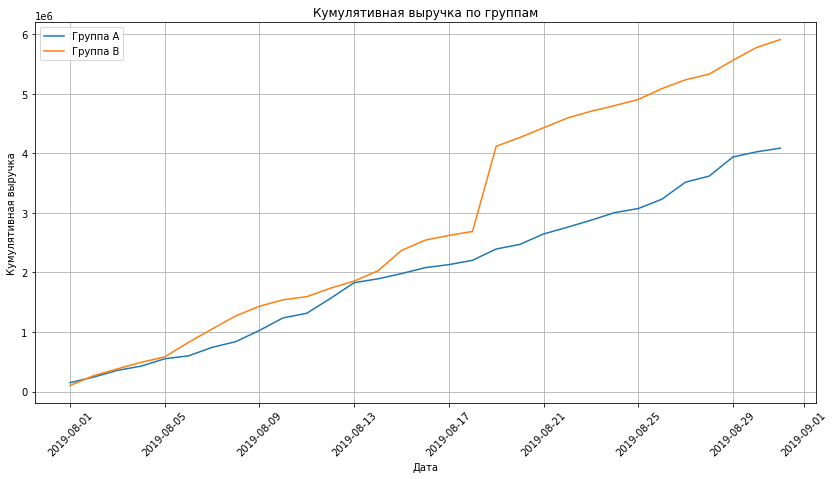

In [16]:
# Сортировка данных по дате и группе
orders_sorted = orders.sort_values(by=['date', 'group'])
# Расчет кумулятивной выручки по дням и группам
cumulative_revenue = orders_sorted.groupby(['date', 'group'])['revenue'].sum().groupby(level=1).cumsum().reset_index()
# Подготовка данных для графиков
cumulative_revenue_a = cumulative_revenue[cumulative_revenue['group'] == 'A']
cumulative_revenue_b = cumulative_revenue[cumulative_revenue['group'] == 'B']
# Построение графика
plt.figure(figsize=(14, 7))
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='Группа A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='Группа B')
plt.title('Кумулятивная выручка по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

На графике кумулятивной выручки видно, что выручка обеих групп увеличивается в течение всего теста. Однако для группы B наблюдается более резкий рост в середине тестового периода - примерно 18.08.2019. Это может указывать на наличие крупных заказов в группе B или более высокую эффективность тестируемых изменений.

- Группа B демонстрирует более высокий рост кумулятивной выручки по сравнению с группой A, что может быть свидетельством более высокой конверсии или наличия крупных заказов.
- Необходимо проанализировать распределение заказов по стоимости, чтобы определить, не искажают ли крупные заказы общую картину.

**2. Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.**

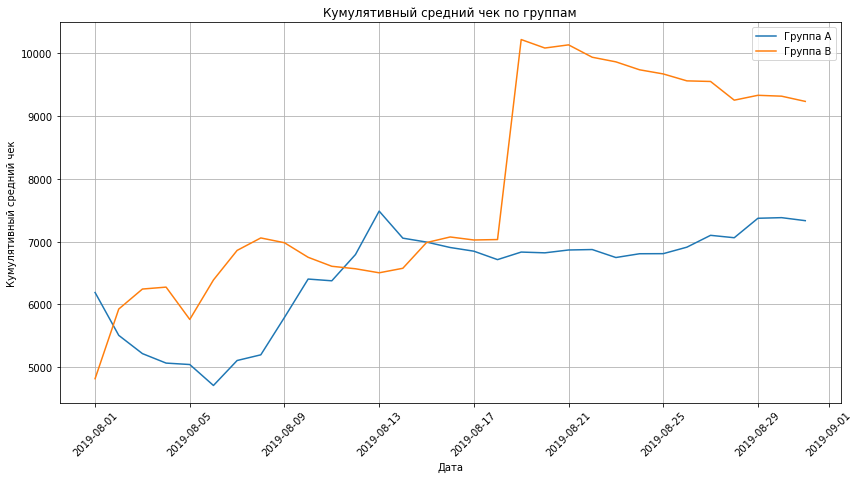

In [17]:
# Расчет кумулятивного среднего чека
cumulative_revenue['cumulative_orders'] = orders_sorted.groupby(['date', 'group']).size().groupby(level=1).cumsum().reset_index(drop=True)
cumulative_revenue['average_check'] = cumulative_revenue['revenue'] / cumulative_revenue['cumulative_orders']
# Подготовка данных для графиков
cumulative_revenue_a = cumulative_revenue[cumulative_revenue['group'] == 'A']
cumulative_revenue_b = cumulative_revenue[cumulative_revenue['group'] == 'B']
# Построение графика
plt.figure(figsize=(14, 7))
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['average_check'], label='Группа A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['average_check'], label='Группа B')
plt.title('Кумулятивный средний чек по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

На графике кумулятивного среднего чека по группам видно, что средний чек группы B значительно превышает средний чек группы A, особенно после резкого скачка в середине периода. Этот скачок может указывать на наличие аномально крупных заказов в группе B. После скачка средний чек группы B постепенно снижается, что может быть следствием увеличения числа заказов с более низкой стоимостью.

- Группа B демонстрирует более высокий средний чек по сравнению с группой A, что может свидетельствовать о повышенной покупательской способности или наличии дорогих заказов.
- Важно провести дополнительный анализ для выявления аномальных заказов, так как они могут искажать общую картину.

**3. Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.**

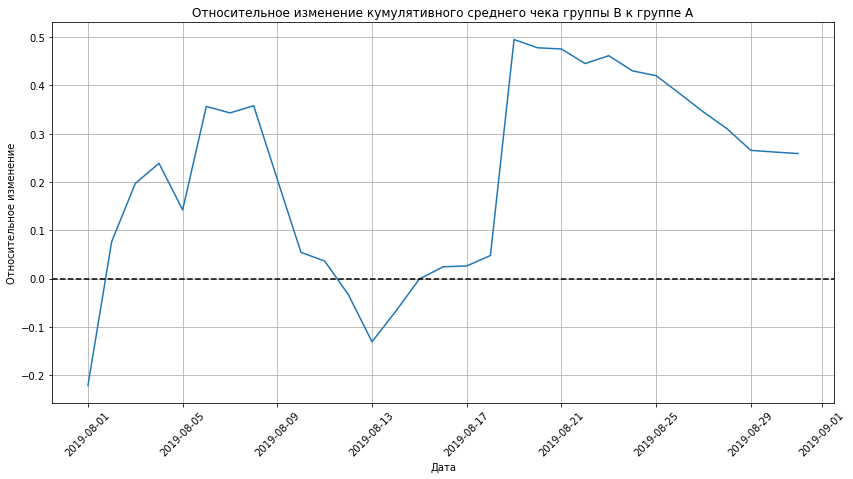

In [18]:
# Слияние данных по среднему чеку двух групп
merged_cumulative_revenue = cumulative_revenue_a[['date', 'average_check']].merge(
    cumulative_revenue_b[['date', 'average_check']], left_on='date', right_on='date', how='left', suffixes=['_a', '_b']
)
# Расчет относительного изменения кумулятивного среднего чека
merged_cumulative_revenue['relative_change'] = (merged_cumulative_revenue['average_check_b'] / merged_cumulative_revenue['average_check_a']) - 1
# Построение графика
plt.figure(figsize=(14, 7))
plt.plot(merged_cumulative_revenue['date'], merged_cumulative_revenue['relative_change'])
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение')
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

На графике относительного изменения кумулятивного среднего чека группы B к группе A видно, что изменения между группами нестабильны на протяжении всего теста. В определенные дни наблюдаются существенные скачки, особенно после резкого роста в середине периода, что подтверждает предположение об аномально крупных заказах в группе B.

- Нестабильность относительного изменения кумулятивного среднего чека указывает на наличие крупных заказов, которые искажают общую картину.
- Для более точной оценки влияния изменений на средний чек необходимо провести анализ аномалий и возможно исключить их из рассмотрения.

**4. Постройте график кумулятивного среднего количества заказов на посетителя по группам. Сделайте выводы и предположения.**

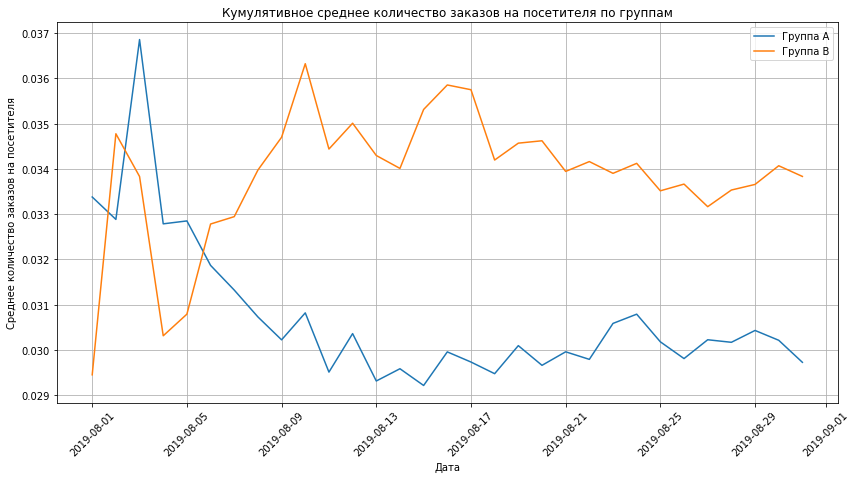

In [19]:
# Расчет кумулятивного количества заказов и посетителей по дням и группам
cumulative_orders = orders_sorted.groupby(['date', 'group']).size().groupby(level=1).cumsum().reset_index(name='cumulative_orders')
cumulative_visitors = visitors.groupby(['date', 'group'])['visitors'].sum().groupby(level=1).cumsum().reset_index(name='cumulative_visitors')
# Слияние данных по группам для расчета среднего количества заказов на посетителя
cumulative_data = cumulative_orders.merge(cumulative_visitors, on=['date', 'group'])
cumulative_data['avg_orders_per_visitor'] = cumulative_data['cumulative_orders'] / cumulative_data['cumulative_visitors']
# Подготовка данных для графиков
cumulative_data_a = cumulative_data[cumulative_data['group'] == 'A']
cumulative_data_b = cumulative_data[cumulative_data['group'] == 'B']
# Построение графика
plt.figure(figsize=(14, 7))
plt.plot(cumulative_data_a['date'], cumulative_data_a['avg_orders_per_visitor'], label='Группа A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['avg_orders_per_visitor'], label='Группа B')
plt.title('Кумулятивное среднее количество заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Среднее количество заказов на посетителя')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

На графике кумулятивного среднего количества заказов на посетителя по группам видно, что значения для обеих групп в целом близки друг к другу на протяжении всего тестового периода. Однако, группа B показывает немного более высокие значения среднего количества заказов на посетителя, особенно в середине периода.

- Группа B немного превосходит группу A по среднему количеству заказов на посетителя, что может свидетельствовать о более высокой конверсии или более эффективном привлечении целевой аудитории.
- Различия между группами не настолько существенны, как в случае среднего чека, что указывает на более равномерное распределение заказов между посетителями.

**5. Постройте график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделайте выводы и предположения.**

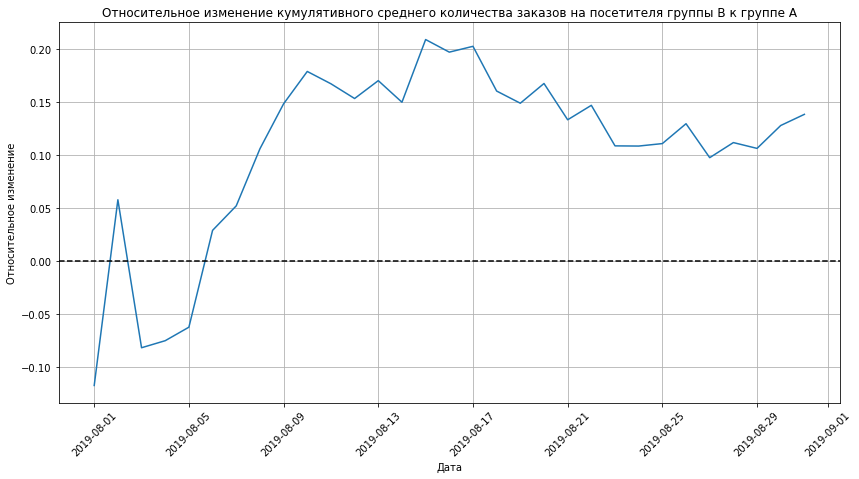

In [20]:
# Слияние данных по среднему количеству заказов на посетителя двух групп
merged_cumulative_orders = cumulative_data_a[['date', 'avg_orders_per_visitor']].merge(
    cumulative_data_b[['date', 'avg_orders_per_visitor']], left_on='date', right_on='date', how='left', suffixes=['_a', '_b']
)
# Расчет относительного изменения кумулятивного среднего количества заказов на посетителя
merged_cumulative_orders['relative_change'] = (merged_cumulative_orders['avg_orders_per_visitor_b'] / merged_cumulative_orders['avg_orders_per_visitor_a']) - 1
# Построение графика
plt.figure(figsize=(14, 7))
plt.plot(merged_cumulative_orders['date'], merged_cumulative_orders['relative_change'])
plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение')
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

На графике относительного изменения кумулятивного среднего количества заказов на посетителя между группами B и A видно, что относительное изменение, в среднем, составляет около 0.10, указывая на то, что группа B в среднем на 10% опережает группу A. Наблюдаются периоды, когда преимущество группы B становится еще более выраженным, особенно заметное в середине тестового периода, после чего различия между группами снова приближаются к среднему уровню преимущества в 10%.

**6. Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.**

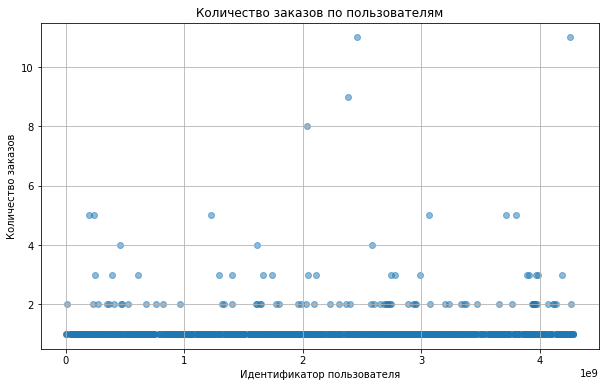

In [21]:
# Подсчет количества заказов по пользователям
orders_by_users = orders.groupby('visitorId').agg({'transactionId': pd.Series.nunique}).reset_index()
orders_by_users.columns = ['visitorId', 'orders']
# Построение точечного графика
plt.figure(figsize=(10, 6))
plt.scatter(orders_by_users['visitorId'], orders_by_users['orders'], alpha=0.5)
plt.title('Количество заказов по пользователям')
plt.xlabel('Идентификатор пользователя')
plt.ylabel('Количество заказов')
plt.grid(True)
plt.show()

In [22]:
# Вывод распределения количества заказов на пользователя
orders_by_users['orders'].describe()

count    1031.000000
mean        1.161009
std         0.724919
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        11.000000
Name: orders, dtype: float64

На точечном графике количества заказов по пользователям видно, что большинство пользователей совершают 1 заказ. Однако существует небольшое количество пользователей, совершающих более одного заказа, и очень немногие из них делают более двух заказов. Максимальное количество заказов на одного пользователя составляет 11.

- Подавляющее большинство пользователей совершают только один заказ за период тестирования, что говорит о высокой доле однократных покупок.
- Наличие пользователей с количеством заказов более одного может указывать на наличие лояльной аудитории или на то, что некоторые пользователи были более активны в период проведения теста.
- Пользователи, совершающие более двух заказов, могут рассматриваться как аномальные, так как они существенно отклоняются от большинства.

**7. Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.**

In [23]:
# Расчет 95-го и 99-го перцентилей количества заказов на пользователя
percentile_orders = np.percentile(orders_by_users['orders'], [95, 99])

percentile_orders

array([2., 4.])

95-й и 99-й перцентили количества заказов на пользователя составляют 2 и 4 соответственно. Это означает, что только 5% пользователей совершают более двух заказов и только 1% пользователей совершают более четырех заказов.

- Для определения аномальных пользователей можно использовать границу в 2 заказа, так как более 95% пользователей совершают не более двух заказов.
- Установление границы аномальных пользователей поможет более точно оценить различия между группами без искажений, вызванных крайне активными пользователями.

**8. Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.**

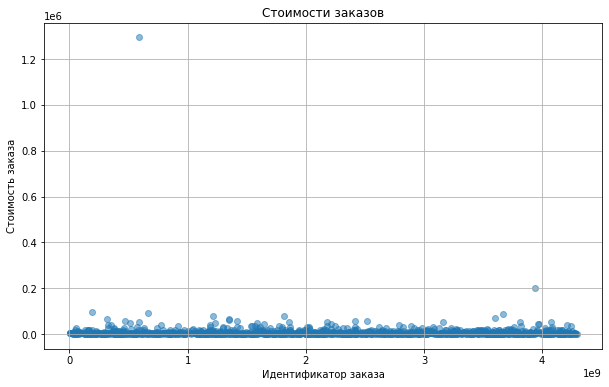

In [24]:
# Построение точечного графика стоимостей заказов
plt.figure(figsize=(10, 6))
plt.scatter(orders['transactionId'], orders['revenue'], alpha=0.5)
plt.title('Стоимости заказов')
plt.xlabel('Идентификатор заказа')
plt.ylabel('Стоимость заказа')
plt.grid(True)
plt.show()

In [25]:
# Вывод распределения стоимостей заказов
orders['revenue'].describe()

count    1.197000e+03
mean     8.348006e+03
std      3.919113e+04
min      5.000000e+01
25%      1.220000e+03
50%      2.978000e+03
75%      8.290000e+03
max      1.294500e+06
Name: revenue, dtype: float64

На точечном графике стоимостей заказов видно, что большинство заказов имеют относительно небольшую стоимость, однако существует несколько заказов с очень высокой стоимостью, в том числе один аномально большой заказ, стоимость которого существенно выше остальных.

- Распределение стоимости заказов сильно скошено из-за наличия нескольких очень дорогих заказов, что может искажать общую картину, особенно при расчете средних значений.

**9. Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.**

In [26]:
# Расчет 95-го и 99-го перцентилей стоимости заказов
percentile_revenue = np.percentile(orders['revenue'], [95, 99])

percentile_revenue

array([28000. , 58233.2])

Эти значения указывают на то, что лишь 5% всех заказов имеют стоимость выше 28000, и только 1% заказов превышает стоимость в 58233.2. На основе этих данных мы можем выбрать нижнюю границу для определения аномальных заказов - 28000.

**10. Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделайте выводы и предположения.**

***Формулировка гипотез:***

- H0: Нет различий в среднем количестве заказов на посетителя между группами A и B.
- H1: Есть различия в среднем количестве заказов на посетителя между группами A и B.

In [27]:
# Подготовка данных количества заказов по группам для группы A
orders_by_users_a = orders[orders['group'] == 'A'].groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique})
orders_by_users_a.columns = ['visitorId', 'orders']

In [28]:
# Подготовка данных количества заказов по группам для группы B
orders_by_users_b = orders[orders['group'] == 'B'].groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique})
orders_by_users_b.columns = ['visitorId', 'orders']

In [29]:
# Подготовка выборок с учетом нулевых значений для пользователей без заказов
sample_a = pd.concat([orders_by_users_a['orders'],pd.Series(0, index=np.arange(visitors[visitors['group'] == 'A']['visitors'].sum() - len(orders_by_users_a)), name='orders')],axis=0)
sample_b = pd.concat([orders_by_users_b['orders'],pd.Series(0, index=np.arange(visitors[visitors['group'] == 'B']['visitors'].sum() - len(orders_by_users_b)), name='orders')],axis=0)

In [30]:
# Применение критерия Манна-Уитни
stat, p_value = mannwhitneyu(sample_a, sample_b)

In [31]:
# Расчет относительного различия в среднем количестве заказов между группами
relative_difference = sample_b.mean() / sample_a.mean() - 1

In [32]:
# Вывод результатов
alpha = 0.05
print(f'P-value: {p_value:.4f}')
if p_value < alpha:
    print(f'Отклоняем нулевую гипотезу: Есть различия в среднем количестве заказов на посетителя между группами A и B.')
else:
    print(f'Не отклоняем нулевую гипотезу: Нет различий в среднем количестве заказов на посетителя между группами A и B.')

print(f'Относительное различие в среднем количестве заказов между группами: {relative_difference:.3f}')

P-value: 0.0168
Отклоняем нулевую гипотезу: Есть различия в среднем количестве заказов на посетителя между группами A и B.
Относительное различие в среднем количестве заказов между группами: 0.138


Статистический тест Манна-Уитни показал, что p-value составляет примерно 0.017, что меньше уровня значимости в 0.05. Это означает, что существуют статистически значимые различия в среднем количестве заказов на посетителя между группами A и B. Относительное различие в среднем количестве заказов между группой B и группой A составляет примерно 13.8%.

Выводы:
- Мы отвергаем нулевую гипотезу о том, что нет различий в среднем количестве заказов на посетителя между группами. Это говорит о том, что изменения, которые были внедрены для группы B, могли повлиять на увеличение количества заказов на посетителя.
- Наблюдается положительное относительное различие в пользу группы B.

**11. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.**

***Формулировка гипотез:***

- H0: Нет различий в среднем чеке заказа между группами A и B.
- H1: Есть различия в среднем чеке заказа между группами A и B.

In [33]:
# Выделение данных по среднему чеку для группы A
revenue_a = orders[orders['group'] == 'A']['revenue']

In [34]:
# Выделение данных по среднему чеку для группы B
revenue_b = orders[orders['group'] == 'B']['revenue']

In [35]:
# Применение критерия Манна-Уитни к данным по среднему чеку
stat, p_value = mannwhitneyu(revenue_a, revenue_b)

In [36]:
# Расчет относительного различия в среднем чеке между группами
relative_difference_revenue = revenue_b.mean() / revenue_a.mean() - 1

In [37]:
# Вывод результатов
alpha = 0.05
print(f'P-value: {p_value:.4f}')

if p_value < alpha:
    print("Отвергаем нулевую гипотезу: Есть различия в среднем чеке заказа между группами A и B.")
else:
    print("Не отвергаем нулевую гипотезу: Нет различий в среднем чеке заказа между группами A и B.")

    print(f'Относительное различие в среднем количестве заказов между группами: {relative_difference_revenue:.2%}')

P-value: 0.7293
Не отвергаем нулевую гипотезу: Нет различий в среднем чеке заказа между группами A и B.
Относительное различие в среднем количестве заказов между группами: 25.87%


Статистический тест Манна-Уитни показал, что p-value составляет примерно 0.729, что значительно выше уровня значимости в 0.05. Это означает, что статистически значимых различий в среднем чеке заказа между группами A и B нет. Однако относительное различие в среднем чеке между группой B и группой A составляет примерно 25.9%.

Выводы:
- Не отвергаем нулевую гипотезу о том, что нет различий в среднем чеке заказа между группами. Это говорит о том, что, несмотря на наличие аномально крупных заказов, в целом изменения, внедренные для группы B, не привели к статистически значимому изменению среднего чека в сравнении с группой A.
- Величина относительного различия указывает на то, что средний чек группы B выше среднего чека группы A, но эти различия не являются статистически значимыми из-за влияния аномальных заказов.

**12. Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделайте выводы и предположения.**

***Формулировка гипотез:***
    
- H0: Нет статистически значимых различий в среднем количестве заказов на посетителя между группами A и B после удаления аномалий.
- H1: Есть статистически значимые различия в среднем количестве заказов на посетителя между группами A и B после удаления аномалий.

In [40]:
# Использование 95-го перцентиля для определения аномальных пользователей по количеству заказов
# Здесь фильтруются пользователи, совершившие более заказов, чем указано 95-м перцентилем
users_with_many_orders = orders_by_users[orders_by_users['orders'] > percentile_orders[0]]['visitorId']

# Использование 95-го перцентиля для определения аномальных заказов по стоимости
# Здесь отбираются заказы, стоимость которых выше значения, указанного 95-м перцентилем
expensive_orders = orders[orders['revenue'] > percentile_revenue[0]]['visitorId']

# Объединение аномальных пользователей в один DataFrame и удаление дубликатов
abnormal_users = pd.concat([users_with_many_orders, expensive_orders], axis=0).drop_duplicates().sort_values()

# Фильтрация данных, исключая аномальных пользователей
filtered_orders_a = orders[(~orders['visitorId'].isin(abnormal_users)) & (orders['group'] == 'A')]
filtered_orders_b = orders[(~orders['visitorId'].isin(abnormal_users)) & (orders['group'] == 'B')]

# Подготовка "очищенных" выборок для среднего количества заказов на посетителя
# Создание выборки, где каждому пользователю соответствует количество его заказов, включая нулевые значения для тех, кто не совершил ни одного заказа
filtered_sample_a = pd.concat([
    filtered_orders_a.groupby('visitorId')['transactionId'].nunique(),
    pd.Series(0, index=np.arange(visitors[visitors['group'] == 'A']['visitors'].sum() - filtered_orders_a['visitorId'].nunique()), name='orders')
], axis=0)

filtered_sample_b = pd.concat([
    filtered_orders_b.groupby('visitorId')['transactionId'].nunique(),
    pd.Series(0, index=np.arange(visitors[visitors['group'] == 'B']['visitors'].sum() - filtered_orders_b['visitorId'].nunique()), name='orders')
], axis=0)

# Применение критерия Манна-Уитни к "очищенным" данным для сравнения среднего количества заказов
stat, p_value = mannwhitneyu(filtered_sample_a, filtered_sample_b)
relative_difference_clean = filtered_sample_b.mean() / filtered_sample_a.mean() - 1

# Вывод результатов анализа
alpha = 0.05
print(f'P-value: {p_value:.4f}')

if p_value < alpha:
    print("Отвергаем нулевую гипотезу: Есть статистически значимые различия в среднем количестве заказов на посетителя между группами A и B после удаления аномалий.")
else:
    print("Не отвергаем нулевую гипотезу: Нет статистически значимых различий в среднем количестве заказов на посетителя между группами A и B после удаления аномалий.")

print(f'Относительное различие в среднем количестве заказов между группами: {relative_difference_clean:.2%}')

P-value: 0.0122
Отвергаем нулевую гипотезу: Есть статистически значимые различия в среднем количестве заказов на посетителя между группами A и B после удаления аномалий.
Относительное различие в среднем количестве заказов между группами: 17.57%


После очистки данных от аномалий и применения критерия Манна-Уитни к "очищенным" данным для среднего количества заказов на посетителя, p-value составляет примерно 0.012. Это меньше уровня значимости в 0.05, что указывает на наличие статистически значимых различий в среднем количестве заказов между группами A и B даже после удаления аномалий. Относительное различие в среднем количестве заказов между группой B и группой A составляет примерно 17.57%.

Выводы по "очищенным" данным:
- Мы снова отвергаем нулевую гипотезу о том, что нет различий в среднем количестве заказов на посетителя между группами A и B после удаления аномалий. Это подтверждает, что изменения, внедренные для группы B, способствуют увеличению количества заказов.
- Увеличение относительного различия после удаления аномалий подтверждает, что аномалии искажали реальную картину.

**13. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.**

***Формулировка гипотез:***
    
- H0: Нет статистически значимых различий в среднем чеке заказа между группами A и B после удаления аномалий.
- H1: Есть статистически значимые различия в среднем чеке заказа между группами A и B после удаления аномалий.


In [39]:
# Применение критерия Манна-Уитни к "очищенным" данным для среднего чека
filtered_revenue_a = filtered_orders_a['revenue']
filtered_revenue_b = filtered_orders_b['revenue']

stat, p_value = mannwhitneyu(filtered_revenue_a, filtered_revenue_b)
relative_difference_revenue_clean = filtered_revenue_b.mean() / filtered_revenue_a.mean() - 1

stat, p_value, relative_difference_revenue_clean

# Вывод результатов
alpha = 0.05
print(f'P-value: {p_value:.3f}')

if p_value < alpha:
    print("Отвергаем нулевую гипотезу: Есть статистически значимые различия в среднем чеке заказа между группами A и B после удаления аномалий.")
else:
    print("Не отвергаем нулевую гипотезу: Нет статистически значимых различий в среднем чеке заказа между группами A и B после удаления аномалий.")


print(f'Относительное различие в среднем количестве заказов между группами: {relative_difference_revenue_clean:.2%}')

P-value: 0.753
Не отвергаем нулевую гипотезу: Нет статистически значимых различий в среднем чеке заказа между группами A и B после удаления аномалий.
Относительное различие в среднем количестве заказов между группами: -2.21%


После очистки данных от аномалий и применения критерия Манна-Уитни к "очищенным" данным для среднего чека, p-value составляет примерно 0.753. Это значительно выше уровня значимости в 0.05, подтверждая отсутствие статистически значимых различий в среднем чеке заказа между группами A и B даже после исключения аномальных заказов. Относительное различие в среднем чеке между группой B и группой A составляет примерно -2.21%, указывая на незначительное снижение среднего чека в группе B по сравнению с группой A после удаления аномалий.

 **Общие выводы по результатам анализа:**
- Среднее количество заказов на посетителя: есть статистически значимые различия между группами как по "сырым", так и по "очищенным" данным, при этом группа B демонстрирует лучшие результаты.
- Средний чек заказа: не было обнаружено статистически значимых различий между группами ни по "сырым", ни по "очищенным" данным. После очистки данных от аномалий средний чек группы B незначительно снизился по сравнению с группой A.

**14. Примите решение по результатам теста и объясните его. Варианты решений:**
1. Остановить тест, зафиксировать победу одной из групп.
2. Остановить тест, зафиксировать отсутствие различий между группами.
3. Продолжить тест.

На основе проведенного анализа результатов A/B-теста, можно принять следующее решение:

1. Остановить тест, зафиксировать победу одной из групп.

Обоснование решения:

Количество заказов на пользователя: Мы обнаружили статистически значимые различия в среднем количестве заказов между группами A и B как по "сырым", так и по "очищенным" данным. Группа B демонстрирует более высокий показатель среднего количества заказов на пользователя, что указывает на успешность внесенных изменений в группе B в отношении привлечения большего количества заказов от пользователей.
Средний чек: Не было обнаружено статистически значимых различий в среднем чеке между группами ни по "сырым", ни по "очищенным" данным. Это означает, что внесенные изменения не повлияли на сумму, которую пользователи тратят за один заказ. Важно отметить, что после исключения аномально крупных заказов различие в среднем чеке между группами стало еще менее значимым.
Принимая во внимание, что основной целью A/B-теста обычно является увеличение эффективности интернет-магазина, в том числе через увеличение количества заказов и оптимизацию среднего чека, можно сделать вывод о том, что изменения, внесенные для группы B, положительно сказались на количестве заказов без ущерба для среднего чека.

Таким образом, группа B демонстрирует лучшие результаты по ключевому показателю количества заказов, что является достаточным основанием для остановки теста и признания победы группы B. Внесенные изменения рекомендуется распространить на всю аудиторию интернет-магазина.

**Общий Вывод:**

В ходе анализа A/B-теста были проведены следующие шаги:

- Предобработка данных: Подготовлены данные без пропусков и дубликатов. Обратили внимание на формат дат, который требовал преобразования для дальнейшего анализа.

- Приоритизация гипотез: Использование фреймворков ICE и RICE для приоритизации гипотез показало изменение приоритетов в зависимости от охвата (Reach).

- Анализ A/B-теста:

 - Кумулятивная выручка и средний чек: Анализ показал резкий рост кумулятивной выручки и среднего чека для группы B, что может указывать на наличие аномально крупных заказов.
 - Кумулятивное количество заказов на посетителя: Незначительные различия между группами, но с небольшим преимуществом у группы B.

- Статистическая значимость:
 - По "сырым" данным, были обнаружены статистически значимые различия в среднем количестве заказов на пользователя между группами, но не в среднем чеке.
 - По "очищенным" данным, подтвердилась значимость различий в количестве заказов, при этом различия в среднем чеке так и не были обнаружены, даже после удаления аномалий.

Исходя из анализа, рекомендуется остановить тест и зафиксировать победу группы B. Причины для этого решения:

- Увеличение количества заказов на пользователя в группе B по сравнению с группой A, что является ключевым показателем успешности внедрённых изменений.
- Отсутствие статистически значимых различий в среднем чеке после исключения аномальных заказов свидетельствует о том, что изменения не нанесли ущерба финансовым показателям интернет-магазина.
- Внесённые изменения для группы B способствовали увеличению количества заказов без существенного влияния на средний чек, что делает их целесообразными для распространения на всю аудиторию интернет-магазина.